<a href="https://colab.research.google.com/github/fauzirfann/dataset-den/blob/main/the-code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Library**

In [1]:
!git clone https://github.com/fauzirfann/dataset-den

Cloning into 'dataset-den'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 4), reused 10 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 4.79 MiB | 19.76 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
import pandas as pd
import numpy as np
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from google.colab import drive
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#1. Colecting Data



In [3]:
dataset = pd.read_csv('/content/dataset-den/DATASETFIXBANGET.csv', sep=None, engine="python",encoding="latin1")

In [4]:
dataset['comment']

,comment
0,Tah dele varel bapak aing
1,Keren
2,Tetap semangaaat kang dedi..klo di pokir korea...
3,"andai dikaltim ngadain begini juga,aku udh iku..."
4,Sy juga pengen??
...,...
9906,"Assalamualaikum pak, punten titip pengawasan s..."
9907,Ko aku nangis liatnya...ada sebuah perubahan k...
9908,"KDM bener2 deh, baru nemu sosok spt beliau. Wa..."
9909,"yg setuju ayo jempolnya dukung KDM, memimpin I..."


**Cek Data Duplikat**

In [5]:
print(dataset.duplicated().sum())

199


In [6]:
dataset.drop_duplicates(inplace = True)
print(dataset.duplicated().sum())

0


**Cek Data Kosong**

In [7]:
print(dataset['comment'].isnull().sum())

1236


In [8]:
df = dataset.dropna(subset=['comment'])

In [9]:
df['comment']

,comment
0,Tah dele varel bapak aing
1,Keren
2,Tetap semangaaat kang dedi..klo di pokir korea...
3,"andai dikaltim ngadain begini juga,aku udh iku..."
4,Sy juga pengen??
...,...
9906,"Assalamualaikum pak, punten titip pengawasan s..."
9907,Ko aku nangis liatnya...ada sebuah perubahan k...
9908,"KDM bener2 deh, baru nemu sosok spt beliau. Wa..."
9909,"yg setuju ayo jempolnya dukung KDM, memimpin I..."


#2. Preprocessing

###1. Cleaning

In [10]:
import re
import string

def clean_text(comment):
    if not isinstance(comment, str):  # cek jika bukan string
        return ''

    # ===== SOLUSI KHUSUS UNTUK QUOT =====
    # Hapus semua variasi 'quot' (termasuk yang menempel di kata lain)
    comment = re.sub(r'\bquot\b', '', comment, flags=re.IGNORECASE)  # kata terpisah
    comment = re.sub(r'quot[^a-zA-Z]', '', comment, flags=re.IGNORECASE)  # di awal kata
    comment = re.sub(r'[^a-zA-Z]quot', '', comment, flags=re.IGNORECASE)  # di akhir kata

    # Untuk kasus ekstrim dimana 'quot' menyatu dengan kata
    comment = re.sub(r'[qQ][uU][oO][tT]', '', comment)  # Tangkap semua variasi case

    # ===== PEMBERSIHAN HTML =====
    # Hapus semua tag HTML (termasuk kasus khusus)
    comment = re.sub(r'<[a-zA-Z][^>]*>.*?</[a-zA-Z]+>', '', comment)  # Tag berpasangan
    comment = re.sub(r'<[a-zA-Z][^>]*>', '', comment)  # Tag tunggal
    comment = re.sub(r'<\w+\s+[^>]*', '', comment)  # Tag tidak lengkap
    comment = re.sub(r'<.*?>', '', comment)  # Pola agresif

    # Hapus entitas HTML (termasuk &quot;)
    comment = re.sub(r'&\w+;', '', comment)  # untuk &quot; &amp; dll

    # ===== PEMBERSIHAN LAINNYA =====
    # URL dan media
    comment = re.sub(r'http[s]?://\S+', '', comment)
    comment = re.sub(r'www\.\S+', '', comment)

    # Markup dan karakter khusus
    comment = re.sub(r'@\w+', '', comment)
    comment = re.sub(r'#\w+', '', comment)
    comment = re.sub(r'\d+', '', comment)

    comment = comment.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    comment = re.sub(r'\s+', ' ', comment)
    comment = comment.strip()

    # Hapus karakter khusus (termasuk sisa tanda baca)
    comment = re.sub(r'[^\w\s]', '', comment)
    comment = re.sub(r'[^\x00-\x7F]+', ' ', comment)
    comment = comment.translate(str.maketrans('', '', string.punctuation))

    # Final cleanup untuk spasi berlebih setelah penghapusan
    comment = re.sub(r'\s+', ' ', comment).strip()
    return comment

df['teks_cleaning'] = df['comment'].apply(clean_text)

/tmp/ipython-input-2152282059.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['teks_cleaning'] = df['comment'].apply(clean_text)


In [11]:
# VALIDASI HASIL CLEANING
print("\n=== Validasi Pembersihan ===")

# 1. Cek sisa HTML
html_check = df[df['teks_cleaning'].str.contains('<|>|a href', regex=True, case=False)]
print(f"\n1. Sisa HTML - {len(html_check)} baris terdeteksi:")
if len(html_check) > 0:
    display(html_check.sample(min(3, len(html_check)), random_state=42)[['teks_cleaning']])

# 2. Cek sisa 'quot' (case insensitive)
quot_check = df[df['teks_cleaning'].str.contains('quot', case=False, regex=False)]
print(f"\n2. Sisa 'quot' - {len(quot_check)} baris terdeteksi:")
if len(quot_check) > 0:
    display(quot_check.sample(min(3, len(quot_check)), random_state=42)[['teks_cleaning']])

# 3. Cek entitas HTML
entity_check = df[df['teks_cleaning'].str.contains('&[a-z]+;', case=False, regex=True)]
print(f"\n3. Sisa entitas HTML - {len(entity_check)} baris terdeteksi:")
if len(entity_check) > 0:
    display(entity_check.sample(min(3, len(entity_check)), random_state=42)[['teks_cleaning']])


=== Validasi Pembersihan ===

1. Sisa HTML - 0 baris terdeteksi:

2. Sisa 'quot' - 0 baris terdeteksi:

3. Sisa entitas HTML - 0 baris terdeteksi:


In [12]:
df[['comment', 'teks_cleaning']]

,comment,teks_cleaning
0,Tah dele varel bapak aing,Tah dele varel bapak aing
1,Keren,Keren
2,Tetap semangaaat kang dedi..klo di pokir korea...,Tetap semangaaat kang dediklo di pokir korea s...
3,"andai dikaltim ngadain begini juga,aku udh iku...",andai dikaltim ngadain begini jugaaku udh ikut
4,Sy juga pengen??,Sy juga pengen
...,...,...
9906,"Assalamualaikum pak, punten titip pengawasan s...",Assalamualaikum pak punten titip pengawasan se...
9907,Ko aku nangis liatnya...ada sebuah perubahan k...,Ko aku nangis liatnyaada sebuah perubahan keci...
9908,"KDM bener2 deh, baru nemu sosok spt beliau. Wa...",KDM bener deh baru nemu sosok spt beliau Wajah...
9909,"yg setuju ayo jempolnya dukung KDM, memimpin I...",yg setuju ayo jempolnya dukung KDM memimpin IN...


###2. Case Folding

In [13]:
def casefolding(comment):
  comment = comment.lower()
  return comment

df['teks_lower'] = df['teks_cleaning'].apply(casefolding)
df[['comment', 'teks_cleaning', 'teks_lower']]

/tmp/ipython-input-4142239699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['teks_lower'] = df['teks_cleaning'].apply(casefolding)


,comment,teks_cleaning,teks_lower
0,Tah dele varel bapak aing,Tah dele varel bapak aing,tah dele varel bapak aing
1,Keren,Keren,keren
2,Tetap semangaaat kang dedi..klo di pokir korea...,Tetap semangaaat kang dediklo di pokir korea s...,tetap semangaaat kang dediklo di pokir korea s...
3,"andai dikaltim ngadain begini juga,aku udh iku...",andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim ngadain begini jugaaku udh ikut
4,Sy juga pengen??,Sy juga pengen,sy juga pengen
...,...,...,...
9906,"Assalamualaikum pak, punten titip pengawasan s...",Assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak punten titip pengawasan se...
9907,Ko aku nangis liatnya...ada sebuah perubahan k...,Ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis liatnyaada sebuah perubahan keci...
9908,"KDM bener2 deh, baru nemu sosok spt beliau. Wa...",KDM bener deh baru nemu sosok spt beliau Wajah...,kdm bener deh baru nemu sosok spt beliau wajah...
9909,"yg setuju ayo jempolnya dukung KDM, memimpin I...",yg setuju ayo jempolnya dukung KDM memimpin IN...,yg setuju ayo jempolnya dukung kdm memimpin in...


In [14]:
dataset['teks_perkata'] = df['teks_lower'].apply(lambda x: x.split())


In [15]:
dataset['teks_perkata']

,teks_perkata
0,"[tah, dele, varel, bapak, aing]"
1,[keren]
2,"[tetap, semangaaat, kang, dediklo, di, pokir, ..."
3,"[andai, dikaltim, ngadain, begini, jugaaku, ud..."
4,"[sy, juga, pengen]"
...,...
9906,"[assalamualaikum, pak, punten, titip, pengawas..."
9907,"[ko, aku, nangis, liatnyaada, sebuah, perubaha..."
9908,"[kdm, bener, deh, baru, nemu, sosok, spt, beli..."
9909,"[yg, setuju, ayo, jempolnya, dukung, kdm, memi..."


In [16]:
# "ledakkan" (explode) jadi perbaris
df_perkata = dataset[['teks_perkata']].explode('teks_perkata')

In [17]:
print(df_perkata.head(10))

  teks_perkata
0          tah
0         dele
0        varel
0        bapak
0         aing
1        keren
2        tetap
2   semangaaat
2         kang
2      dediklo


In [18]:
df_perkata.to_csv("kamus.csv", index=False)

In [19]:
# prompt: cek jumlah data kosong setelah lower teks

print("\n=== Cek Data Kosong Setelah Lower Teks ===")
print(f"Jumlah data kosong pada kolom 'teks_lower': {df['teks_lower'].isnull().sum()}")



=== Cek Data Kosong Setelah Lower Teks ===
Jumlah data kosong pada kolom 'teks_lower': 0


In [20]:
dataset['teks_perkata'].to_csv("normalisasi.csv", index=False)

**Upload Kamus Kata Baku**

In [21]:
import re

def replace_taboo_words(text, kamus_tidak_baku):
    if isinstance(text, str):
        words = re.findall(r'\b\w+\b', text)  # Memastikan hanya kata-kata yang valid yang diambil
        replaced_words = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

        for word in words:
            if word in kamus_tidak_baku:
                baku_word = kamus_tidak_baku[word]
                # Check if baku_word is a string before splitting
                if isinstance(baku_word, str):
                    replaced_words.extend(baku_word.split())  # Memisahkan frasa menjadi beberapa kata
                    kalimat_baku.append(baku_word)
                    kata_diganti.append(word)
                    kata_tidak_baku_hash.append(hash(word))
                else:
                    # Handle non-string values (e.g., NaN) by skipping or converting
                    replaced_words.append(word) # Or you might choose to skip the word entirely
            else:
                replaced_words.append(word)

        replaced_text = ' '.join(replaced_words)
    else:
        replaced_text = ''
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

    return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash

In [22]:
datanormalisasi = pd.read_excel('/content/dataset-den/kamus_v2(1).xlsx')

In [23]:
datanormalisasi

,teks_tidakbaku,teks_baku
0,andai,andai
1,aja,saja
2,ada,ada
3,kau,kamu
4,jadi,jadi
...,...,...
20349,semangaaat,semangat
20350,dediklo,kdm
20351,jugaaku,juga aku
20352,aing,saya


In [24]:
# kamus = pd.read_excel('/content/drive/MyDrive/SKRIPSI/kamus_v2(1).xlsx')
# kamus.head()
kamus_tidak_baku = dict(zip(datanormalisasi['teks_tidakbaku'], datanormalisasi['teks_baku']))

In [25]:
kamus_tidak_baku

{'andai': 'andai',
 'aja': 'aja',
 'ada': 'ada',
 'kau': 'kamu',
 'jadi': 'jadi',
 'preseden': 'preseden',
 'pak': 'pak',
 'pas': 'pas',
 'maju': 'maju',
 'ini': 'ini',
 'negara': 'negara',
 'assalamualaikum': 'assalamualaikum',
 'pa': 'pa',
 'gimana': 'gimana',
 'caranya': 'caranya',
 'agar': 'agar',
 'saya': 'saya',
 'bisa': 'bisa',
 'nitipkan': 'nitipkan',
 'anak': 'anak',
 'tidak': 'tidak',
 'mau': 'mau',
 'sekolah': 'sekolah',
 'smp': 'sampai',
 'ikut': 'ikut',
 'genk': 'geng',
 'motor': 'motor',
 'sampai': 'sampai',
 'bangke': 'bangkai',
 'udah': 'udah',
 'segala': 'segala',
 'barang': 'barang',
 'dirumah': 'dirumah',
 'dijualin': 'dijual',
 'buat': 'buat',
 'main': 'main',
 'slot': 'slot',
 'sama': 'sama',
 'minum': 'minum',
 'uang': 'uang',
 'sering': 'sering',
 'diambil': 'diambil',
 'dikasih': 'dikasih',
 'hp': 'hp',
 'dijual': 'dujual',
 'sudah': 'sudah',
 'ngga': 'tidak',
 'sanggup': 'sanggup',
 'kpai': 'kpai',
 'resah': 'resah',
 'dedy': 'dedy',
 'yang': 'yang',
 'cowok': 

###3. Normalisasi

In [26]:
# Jika df berasal dari subset/filtering, pastikan membuat salinan eksplisit
df = df.copy()

# Terapkan fungsi penggantian kata tidak baku dengan aman menggunakan .loc dan ambil hasil dari replace_taboo_words dan pecah menjadi kolom yang sesuai
df[['teks_normalisasi', 'kata_baku', 'kata_tidak_baku', 'kata_tidak_baku_hash']] = df['teks_lower'].apply(lambda x: pd.Series(replace_taboo_words(x, kamus_tidak_baku)))

# Ambil kolom yang diperlukan
df = pd.DataFrame(df[['comment', 'teks_cleaning', 'teks_lower', 'teks_normalisasi']])

# Simpan DataFrame ke file CSV
df.to_csv('hasilnormalisasi.csv', index=False, header=True)

# Tampilkan DataFrame

In [27]:
df['teks_lower'] = df['teks_cleaning'].str.lower()
print(df[['teks_cleaning', 'teks_lower']].head())


                                       teks_cleaning  \
0                          Tah dele varel bapak aing   
1                                              Keren   
2  Tetap semangaaat kang dediklo di pokir korea s...   
3     andai dikaltim ngadain begini jugaaku udh ikut   
4                                     Sy juga pengen   

                                          teks_lower  
0                          tah dele varel bapak aing  
1                                              keren  
2  tetap semangaaat kang dediklo di pokir korea s...  
3     andai dikaltim ngadain begini jugaaku udh ikut  
4                                     sy juga pengen  


In [28]:
df['teks_lower'] = df['teks_cleaning'].str.lower()


In [29]:
df['teks_lower'] = df['teks_lower'].fillna('').astype(str)


In [30]:
print(df['teks_lower'].head())


0                            tah dele varel bapak aing
1                                                keren
2    tetap semangaaat kang dediklo di pokir korea s...
3       andai dikaltim ngadain begini jugaaku udh ikut
4                                       sy juga pengen
Name: teks_lower, dtype: object


In [31]:
df

,comment,teks_cleaning,teks_lower,teks_normalisasi
0,Tah dele varel bapak aing,Tah dele varel bapak aing,tah dele varel bapak aing,tah dele varel bapak saya
1,Keren,Keren,keren,keren
2,Tetap semangaaat kang dedi..klo di pokir korea...,Tetap semangaaat kang dediklo di pokir korea s...,tetap semangaaat kang dediklo di pokir korea s...,tetap semangat kang kdm di pokir korea selatan...
3,"andai dikaltim ngadain begini juga,aku udh iku...",andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim mengadakan begini juga aku suda...
4,Sy juga pengen??,Sy juga pengen,sy juga pengen,saya juga pengen
...,...,...,...,...
9906,"Assalamualaikum pak, punten titip pengawasan s...",Assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak permisi titip pengawasan s...
9907,Ko aku nangis liatnya...ada sebuah perubahan k...,Ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis lihatnya ada sebuah perubahan ke...
9908,"KDM bener2 deh, baru nemu sosok spt beliau. Wa...",KDM bener deh baru nemu sosok spt beliau Wajah...,kdm bener deh baru nemu sosok spt beliau wajah...,kdm bener deh baru menemukan sosok seperti bel...
9909,"yg setuju ayo jempolnya dukung KDM, memimpin I...",yg setuju ayo jempolnya dukung KDM memimpin IN...,yg setuju ayo jempolnya dukung kdm memimpin in...,yang setuju ayo jempolnya dukung kdm memimpin ...


In [32]:
print(df['teks_lower'].head())
print(df['teks_lower'].apply(type).value_counts())


0                            tah dele varel bapak aing
1                                                keren
2    tetap semangaaat kang dediklo di pokir korea s...
3       andai dikaltim ngadain begini jugaaku udh ikut
4                                       sy juga pengen
Name: teks_lower, dtype: object
teks_lower
<class 'str'>    8476
Name: count, dtype: int64


In [33]:
df[['teks_lower', 'teks_normalisasi']].head()


,teks_lower,teks_normalisasi
0,tah dele varel bapak aing,tah dele varel bapak saya
1,keren,keren
2,tetap semangaaat kang dediklo di pokir korea s...,tetap semangat kang kdm di pokir korea selatan...
3,andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim mengadakan begini juga aku suda...
4,sy juga pengen,saya juga pengen


###4. Tokenized

In [34]:
import shutil
shutil.rmtree('/root/nltk_data', ignore_errors=True)


In [35]:
import nltk
nltk.download('punkt')
#nltk.data.find('tokenizers/punkt')  # <-- Tambahkan baris ini
nltk.data.path.append('/root/nltk_data')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [36]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()
df['teks_tokenization'] = df['teks_normalisasi'].fillna('').astype(str).apply(tokenizer.tokenize)


In [37]:
# Lihat 5 hasil teratas setelah tokenisasi
df[['teks_normalisasi', 'teks_tokenization']].head()


,teks_normalisasi,teks_tokenization
0,tah dele varel bapak saya,"[tah, dele, varel, bapak, saya]"
1,keren,[keren]
2,tetap semangat kang kdm di pokir korea selatan...,"[tetap, semangat, kang, kdm, di, pokir, korea,..."
3,andai dikaltim mengadakan begini juga aku suda...,"[andai, dikaltim, mengadakan, begini, juga, ak..."
4,saya juga pengen,"[saya, juga, pengen]"


In [38]:
df

,comment,teks_cleaning,teks_lower,teks_normalisasi,teks_tokenization
0,Tah dele varel bapak aing,Tah dele varel bapak aing,tah dele varel bapak aing,tah dele varel bapak saya,"[tah, dele, varel, bapak, saya]"
1,Keren,Keren,keren,keren,[keren]
2,Tetap semangaaat kang dedi..klo di pokir korea...,Tetap semangaaat kang dediklo di pokir korea s...,tetap semangaaat kang dediklo di pokir korea s...,tetap semangat kang kdm di pokir korea selatan...,"[tetap, semangat, kang, kdm, di, pokir, korea,..."
3,"andai dikaltim ngadain begini juga,aku udh iku...",andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim mengadakan begini juga aku suda...,"[andai, dikaltim, mengadakan, begini, juga, ak..."
4,Sy juga pengen??,Sy juga pengen,sy juga pengen,saya juga pengen,"[saya, juga, pengen]"
...,...,...,...,...,...
9906,"Assalamualaikum pak, punten titip pengawasan s...",Assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak permisi titip pengawasan s...,"[assalamualaikum, pak, permisi, titip, pengawa..."
9907,Ko aku nangis liatnya...ada sebuah perubahan k...,Ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis lihatnya ada sebuah perubahan ke...,"[ko, aku, nangis, lihatnya, ada, sebuah, perub..."
9908,"KDM bener2 deh, baru nemu sosok spt beliau. Wa...",KDM bener deh baru nemu sosok spt beliau Wajah...,kdm bener deh baru nemu sosok spt beliau wajah...,kdm bener deh baru menemukan sosok seperti bel...,"[kdm, bener, deh, baru, menemukan, sosok, sepe..."
9909,"yg setuju ayo jempolnya dukung KDM, memimpin I...",yg setuju ayo jempolnya dukung KDM memimpin IN...,yg setuju ayo jempolnya dukung kdm memimpin in...,yang setuju ayo jempolnya dukung kdm memimpin ...,"[yang, setuju, ayo, jempolnya, dukung, kdm, me..."


###5. Stopword

In [39]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.1 MB/s eta 0:00:00


In [40]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

def proces_text(text):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()

    # Jika input berupa list, gabungkan dulu jadi string
    if isinstance(text, list):
        text = ' '.join(text)

    # Proses stopword removal dengan Sastrawi
    text = stopword.remove(text)

    # Tambahan stopword custom manual
    tambahan_stopword = [
    'hahaha', 'haha', 'ha', 'itu', 'tuh', 'hihi', 'hihihi', 'kok', 'amp', 'a', 'ds', 'dong', 'guys',
    'coeg', 'ini', 'nih', 'niich', 'broo', 'tsk', 'auuu', 'ngab', 'behh', 'huh', 'sih', 'kan',
    'wa', 'bt', 'coy', 'eh', 'quotlh', 'bi', 'si', 'do', 'woy', 'hei', 'halah', 'ih',
    'eergh', 'cukkk', 'vhh', 'brudddssssd', 'hehehe', 'deh', 'lah', 'lho', 'loh',
    'toh', 'atuh', 'yah', 'laaa', 'di', 'toh', 'kalau', 'mah', 'mh', 'nya', 'ahh', 'ah',
    'oh', 'eh', 'lahh', 'seh', 'wow', 'aa', 'l csrnya', 'buk', 'mbok', 'book', 'sr',
    'bosss', 'ge', 'digass', 'e', 'he', 'le', 'wah', 'beh', 'ber'
    ]


    words = text.split()
    filtered_words = [word for word in words if word not in tambahan_stopword]
    text = ' '.join(filtered_words)

    return text

# Terapkan fungsi ke dataframe
df['teks_stopwordremoved'] = df['teks_tokenization'].apply(proces_text)
df.to_csv('hasil_stopword.csv', index =False)
df

,comment,teks_cleaning,teks_lower,teks_normalisasi,teks_tokenization,teks_stopwordremoved
0,Tah dele varel bapak aing,Tah dele varel bapak aing,tah dele varel bapak aing,tah dele varel bapak saya,"[tah, dele, varel, bapak, saya]",tah dele varel bapak
1,Keren,Keren,keren,keren,[keren],keren
2,Tetap semangaaat kang dedi..klo di pokir korea...,Tetap semangaaat kang dediklo di pokir korea s...,tetap semangaaat kang dediklo di pokir korea s...,tetap semangat kang kdm di pokir korea selatan...,"[tetap, semangat, kang, kdm, di, pokir, korea,...",tetap semangat kang kdm pokir korea selatan ma...
3,"andai dikaltim ngadain begini juga,aku udh iku...",andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim mengadakan begini juga aku suda...,"[andai, dikaltim, mengadakan, begini, juga, ak...",andai dikaltim mengadakan begini aku ikut
4,Sy juga pengen??,Sy juga pengen,sy juga pengen,saya juga pengen,"[saya, juga, pengen]",juga pengen
...,...,...,...,...,...,...
9906,"Assalamualaikum pak, punten titip pengawasan s...",Assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak permisi titip pengawasan s...,"[assalamualaikum, pak, permisi, titip, pengawa...",assalamualaikum pak permisi titip pengawasan k...
9907,Ko aku nangis liatnya...ada sebuah perubahan k...,Ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis lihatnya ada sebuah perubahan ke...,"[ko, aku, nangis, lihatnya, ada, sebuah, perub...",ko aku nangis lihatnya sebuah perubahan kecil ...
9908,"KDM bener2 deh, baru nemu sosok spt beliau. Wa...",KDM bener deh baru nemu sosok spt beliau Wajah...,kdm bener deh baru nemu sosok spt beliau wajah...,kdm bener deh baru menemukan sosok seperti bel...,"[kdm, bener, deh, baru, menemukan, sosok, sepe...",kdm bener baru menemukan sosok beliau wajahnya...
9909,"yg setuju ayo jempolnya dukung KDM, memimpin I...",yg setuju ayo jempolnya dukung KDM memimpin IN...,yg setuju ayo jempolnya dukung kdm memimpin in...,yang setuju ayo jempolnya dukung kdm memimpin ...,"[yang, setuju, ayo, jempolnya, dukung, kdm, me...",setuju ayo jempolnya dukung kdm memimpin indon...


###6. Stemming

In [41]:
# Import StemmerFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Buat objek stemmer
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

# Fungsi untuk stemming
def stem_text(text):
    if isinstance(text, str):
        tokens = text.split()  # ubah kalimat jadi list kata
        return [stemmer.stem(word) for word in tokens]
    return []


# Terapkan ke kolom stopword_removed
df['teks_stemming'] = df['teks_stopwordremoved'].apply(stem_text)

# Lihat hasilnya
df[['teks_tokenization', 'teks_stopwordremoved', 'teks_stemming']].head()

,teks_tokenization,teks_stopwordremoved,teks_stemming
0,"[tah, dele, varel, bapak, saya]",tah dele varel bapak,"[tah, dele, varel, bapak]"
1,[keren],keren,[keren]
2,"[tetap, semangat, kang, kdm, di, pokir, korea,...",tetap semangat kang kdm pokir korea selatan ma...,"[tetap, semangat, kang, kdm, pokir, korea, sel..."
3,"[andai, dikaltim, mengadakan, begini, juga, ak...",andai dikaltim mengadakan begini aku ikut,"[andai, dikaltim, ada, begini, aku, ikut]"
4,"[saya, juga, pengen]",juga pengen,"[juga, ken]"


In [42]:
df['teks_stemming'] = df['teks_stemming'].apply(lambda x: ' '.join(x))

In [43]:
df['teks_stopwordremoved'] = df['teks_stopwordremoved'].apply(lambda x: x.split() if isinstance(x, str) else x)

In [44]:
df[['comment', 'teks_cleaning', 'teks_lower', 'teks_normalisasi', 'teks_tokenization', 'teks_stopwordremoved', 'teks_stemming']]

,comment,teks_cleaning,teks_lower,teks_normalisasi,teks_tokenization,teks_stopwordremoved,teks_stemming
0,Tah dele varel bapak aing,Tah dele varel bapak aing,tah dele varel bapak aing,tah dele varel bapak saya,"[tah, dele, varel, bapak, saya]","[tah, dele, varel, bapak]",tah dele varel bapak
1,Keren,Keren,keren,keren,[keren],[keren],keren
2,Tetap semangaaat kang dedi..klo di pokir korea...,Tetap semangaaat kang dediklo di pokir korea s...,tetap semangaaat kang dediklo di pokir korea s...,tetap semangat kang kdm di pokir korea selatan...,"[tetap, semangat, kang, kdm, di, pokir, korea,...","[tetap, semangat, kang, kdm, pokir, korea, sel...",tetap semangat kang kdm pokir korea selatan ma...
3,"andai dikaltim ngadain begini juga,aku udh iku...",andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim mengadakan begini juga aku suda...,"[andai, dikaltim, mengadakan, begini, juga, ak...","[andai, dikaltim, mengadakan, begini, aku, ikut]",andai dikaltim ada begini aku ikut
4,Sy juga pengen??,Sy juga pengen,sy juga pengen,saya juga pengen,"[saya, juga, pengen]","[juga, pengen]",juga ken
...,...,...,...,...,...,...,...
9906,"Assalamualaikum pak, punten titip pengawasan s...",Assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak permisi titip pengawasan s...,"[assalamualaikum, pak, permisi, titip, pengawa...","[assalamualaikum, pak, permisi, titip, pengawa...",assalamualaikum pak permisi titip awas keluar ...
9907,Ko aku nangis liatnya...ada sebuah perubahan k...,Ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis lihatnya ada sebuah perubahan ke...,"[ko, aku, nangis, lihatnya, ada, sebuah, perub...","[ko, aku, nangis, lihatnya, sebuah, perubahan,...",ko aku nang lihat buah ubah kecil sana masa depan
9908,"KDM bener2 deh, baru nemu sosok spt beliau. Wa...",KDM bener deh baru nemu sosok spt beliau Wajah...,kdm bener deh baru nemu sosok spt beliau wajah...,kdm bener deh baru menemukan sosok seperti bel...,"[kdm, bener, deh, baru, menemukan, sosok, sepe...","[kdm, bener, baru, menemukan, sosok, beliau, w...",kdm bener baru temu sosok beliau wajah lelah t...
9909,"yg setuju ayo jempolnya dukung KDM, memimpin I...",yg setuju ayo jempolnya dukung KDM memimpin IN...,yg setuju ayo jempolnya dukung kdm memimpin in...,yang setuju ayo jempolnya dukung kdm memimpin ...,"[yang, setuju, ayo, jempolnya, dukung, kdm, me...","[setuju, ayo, jempolnya, dukung, kdm, memimpin...",tuju ayo jempol dukung kdm pimpin indonesia


#3. Upload Kamus Senticnet

In [45]:
label_xls = pd.read_excel('/content/dataset-den/senticnet.xlsx')
label_df = pd.DataFrame(label_xls)
lexicon_dict = dict(zip(label_df['CONCEPT'], label_df['POLARITY INTENSITY']))


In [46]:
lexicon_dict

{'aah': -0.56,
 'abadi': 0.964,
 'abdominoplasti': 0.29,
 'aberrate': -0.554,
 'abey': -0.329,
 'ablare': -0.878,
 'ablasi_eyestalk': -0.886,
 'ablasi_kateter': -0.855,
 'ablast': -0.989,
 'abnormal': -0.3,
 'abomasum': -0.215,
 'abortifasient': 0.625,
 'abortisida': -0.79,
 'aboulia': -0.88,
 'aboulik': 0.966,
 'abrasi': -0.169,
 'abreaksi': 0.612,
 'absen': -0.829,
 'absentmind': -0.828,
 'absis': -0.852,
 'absolutepunk': -0.701,
 'absolutif': -0.865,
 'absolutist': -0.825,
 'absolvitasi': 0.84,
 'absquatulate': -0.988,
 'abstain_dari': -0.549,
 'abstensi': 0.523,
 'abstraktif': -0.843,
 'abu_abu': -0.312,
 'abu_abu_belang': -0.82,
 'abu_abu_silver': 0.56,
 'abu_abu_suram': -0.498,
 'abulia': -0.983,
 'ac_id': -0.833,
 'acak': -0.827,
 'acalculia': -0.519,
 'acanthamoeba': -0.256,
 'acanthocephalan': -0.833,
 'acara_sosial': 0.639,
 'acaricide': -0.548,
 'acausal': 0.859,
 'accelerator_proton': -0.882,
 'ace_in_hole': 0.885,
 'ace_payudara': 0.253,
 'ace_sooty': 0.805,
 'ace_up_sleev

In [47]:
def kamus_sentimen(t):
    score = []  # List untuk menyimpan skor dari setiap kata
    polarity = ''  # Variabel untuk menyimpan label sentimen

    # Iterasi setiap kata dalam teks
    for w in t :
        if w in kamus_sentimen:  # Jika kata ada dalam kamus lexicon
            score.append(float(kamus_sentimen.get(w)))  # Tambahkan skornya ke list

    # Hitung total score
    total_score = sum(score)

    # Tentukan sentimen berdasarkan total score
    if total_score > 0:
        polarity = 'positive'
    else:
        polarity = 'negative'

    return polarity, total_score

In [48]:
df

,comment,teks_cleaning,teks_lower,teks_normalisasi,teks_tokenization,teks_stopwordremoved,teks_stemming
0,Tah dele varel bapak aing,Tah dele varel bapak aing,tah dele varel bapak aing,tah dele varel bapak saya,"[tah, dele, varel, bapak, saya]","[tah, dele, varel, bapak]",tah dele varel bapak
1,Keren,Keren,keren,keren,[keren],[keren],keren
2,Tetap semangaaat kang dedi..klo di pokir korea...,Tetap semangaaat kang dediklo di pokir korea s...,tetap semangaaat kang dediklo di pokir korea s...,tetap semangat kang kdm di pokir korea selatan...,"[tetap, semangat, kang, kdm, di, pokir, korea,...","[tetap, semangat, kang, kdm, pokir, korea, sel...",tetap semangat kang kdm pokir korea selatan ma...
3,"andai dikaltim ngadain begini juga,aku udh iku...",andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim mengadakan begini juga aku suda...,"[andai, dikaltim, mengadakan, begini, juga, ak...","[andai, dikaltim, mengadakan, begini, aku, ikut]",andai dikaltim ada begini aku ikut
4,Sy juga pengen??,Sy juga pengen,sy juga pengen,saya juga pengen,"[saya, juga, pengen]","[juga, pengen]",juga ken
...,...,...,...,...,...,...,...
9906,"Assalamualaikum pak, punten titip pengawasan s...",Assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak permisi titip pengawasan s...,"[assalamualaikum, pak, permisi, titip, pengawa...","[assalamualaikum, pak, permisi, titip, pengawa...",assalamualaikum pak permisi titip awas keluar ...
9907,Ko aku nangis liatnya...ada sebuah perubahan k...,Ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis lihatnya ada sebuah perubahan ke...,"[ko, aku, nangis, lihatnya, ada, sebuah, perub...","[ko, aku, nangis, lihatnya, sebuah, perubahan,...",ko aku nang lihat buah ubah kecil sana masa depan
9908,"KDM bener2 deh, baru nemu sosok spt beliau. Wa...",KDM bener deh baru nemu sosok spt beliau Wajah...,kdm bener deh baru nemu sosok spt beliau wajah...,kdm bener deh baru menemukan sosok seperti bel...,"[kdm, bener, deh, baru, menemukan, sosok, sepe...","[kdm, bener, baru, menemukan, sosok, beliau, w...",kdm bener baru temu sosok beliau wajah lelah t...
9909,"yg setuju ayo jempolnya dukung KDM, memimpin I...",yg setuju ayo jempolnya dukung KDM memimpin IN...,yg setuju ayo jempolnya dukung kdm memimpin in...,yang setuju ayo jempolnya dukung kdm memimpin ...,"[yang, setuju, ayo, jempolnya, dukung, kdm, me...","[setuju, ayo, jempolnya, dukung, kdm, memimpin...",tuju ayo jempol dukung kdm pimpin indonesia


**Mencari Kemiripan Kata di kolom *tokenized_stemming* dengan *Senticnet***

In [49]:
def merge_phrases(tokens, phrase_dict):
    i = 0
    new_tokens = []
    while i < len(tokens) - 1:
        pair = (tokens[i], tokens[i+1])
        if pair in phrase_dict:
            new_tokens.append(phrase_dict[pair])
            i += 2
        else:
            new_tokens.append(tokens[i])
            i += 1
    if i == len(tokens) - 1:
        new_tokens.append(tokens[i])
    return new_tokens

In [50]:
df['text_correct_senticnet'] = df['teks_stemming'].apply(lambda x: merge_phrases(x.split(), lexicon_dict))

#4. Menentukan Sentimen Berdasarkan Total Score

In [51]:
def sentimen_lexicon(t):
    score = []  # List untuk menyimpan skor dari setiap kata
    polarity = ''  # Variabel untuk menyimpan label sentimen

    # Iterasi setiap kata dalam teks
    for w in t :
        if w in lexicon_dict:  # Jika kata ada dalam kamus lexicon
            score.append(float(lexicon_dict.get(w)))  # Tambahkan skornya ke list

    # Hitung total score
    total_score = sum(score)

    # Tentukan sentimen berdasarkan total score
    if total_score > 0:
        polarity = 'positive'
    else:
        polarity = 'negative'

    return polarity, total_score

**Memberi *Polarity Score* ke kolom *text_correct_senticnet***

In [52]:
label_result = df['text_correct_senticnet'].apply(sentimen_lexicon)
label_result = list(zip(*label_result))

df['polarity'] = label_result[0]
df['polarity_score'] = label_result[1]

In [53]:
df.to_csv('sentimen hasil label.csv', index = False, header = True,index_label=None)
df

,comment,teks_cleaning,teks_lower,teks_normalisasi,teks_tokenization,teks_stopwordremoved,teks_stemming,text_correct_senticnet,polarity,polarity_score
0,Tah dele varel bapak aing,Tah dele varel bapak aing,tah dele varel bapak aing,tah dele varel bapak saya,"[tah, dele, varel, bapak, saya]","[tah, dele, varel, bapak]",tah dele varel bapak,"[tah, dele, varel, bapak]",positive,0.844
1,Keren,Keren,keren,keren,[keren],[keren],keren,[keren],positive,0.659
2,Tetap semangaaat kang dedi..klo di pokir korea...,Tetap semangaaat kang dediklo di pokir korea s...,tetap semangaaat kang dediklo di pokir korea s...,tetap semangat kang kdm di pokir korea selatan...,"[tetap, semangat, kang, kdm, di, pokir, korea,...","[tetap, semangat, kang, kdm, pokir, korea, sel...",tetap semangat kang kdm pokir korea selatan ma...,"[tetap, semangat, kang, kdm, pokir, korea, sel...",positive,0.319
3,"andai dikaltim ngadain begini juga,aku udh iku...",andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim ngadain begini jugaaku udh ikut,andai dikaltim mengadakan begini juga aku suda...,"[andai, dikaltim, mengadakan, begini, juga, ak...","[andai, dikaltim, mengadakan, begini, aku, ikut]",andai dikaltim ada begini aku ikut,"[andai, dikaltim, ada, begini, aku, ikut]",positive,1.738
4,Sy juga pengen??,Sy juga pengen,sy juga pengen,saya juga pengen,"[saya, juga, pengen]","[juga, pengen]",juga ken,"[juga, ken]",positive,0.521
...,...,...,...,...,...,...,...,...,...,...
9906,"Assalamualaikum pak, punten titip pengawasan s...",Assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak punten titip pengawasan se...,assalamualaikum pak permisi titip pengawasan s...,"[assalamualaikum, pak, permisi, titip, pengawa...","[assalamualaikum, pak, permisi, titip, pengawa...",assalamualaikum pak permisi titip awas keluar ...,"[assalamualaikum, pak, permisi, titip, awas, k...",negative,-2.105
9907,Ko aku nangis liatnya...ada sebuah perubahan k...,Ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis liatnyaada sebuah perubahan keci...,ko aku nangis lihatnya ada sebuah perubahan ke...,"[ko, aku, nangis, lihatnya, ada, sebuah, perub...","[ko, aku, nangis, lihatnya, sebuah, perubahan,...",ko aku nang lihat buah ubah kecil sana masa depan,"[ko, aku, nang, lihat, buah, ubah, kecil, sana...",positive,1.946
9908,"KDM bener2 deh, baru nemu sosok spt beliau. Wa...",KDM bener deh baru nemu sosok spt beliau Wajah...,kdm bener deh baru nemu sosok spt beliau wajah...,kdm bener deh baru menemukan sosok seperti bel...,"[kdm, bener, deh, baru, menemukan, sosok, sepe...","[kdm, bener, baru, menemukan, sosok, beliau, w...",kdm bener baru temu sosok beliau wajah lelah t...,"[kdm, bener, baru, temu, sosok, beliau, wajah,...",positive,2.790
9909,"yg setuju ayo jempolnya dukung KDM, memimpin I...",yg setuju ayo jempolnya dukung KDM memimpin IN...,yg setuju ayo jempolnya dukung kdm memimpin in...,yang setuju ayo jempolnya dukung kdm memimpin ...,"[yang, setuju, ayo, jempolnya, dukung, kdm, me...","[setuju, ayo, jempolnya, dukung, kdm, memimpin...",tuju ayo jempol dukung kdm pimpin indonesia,"[tuju, ayo, jempol, dukung, kdm, pimpin, indon...",negative,-0.142


**Melihat Total Sentimen Positif dan Negatif**

In [55]:
komen_positif=df[df['polarity'] == 'positive']
komen_negative=df[df['polarity'] == 'negative']

total_komen=len(komen_positif)+len(komen_negative)
print(len(komen_positif), "({}%)".format(100*len(komen_positif)/total_komen))
print(len(komen_negative), "({}%)".format(100*len(komen_negative)/total_komen))

6120 (72.20386974988202%)
2356 (27.79613025011798%)


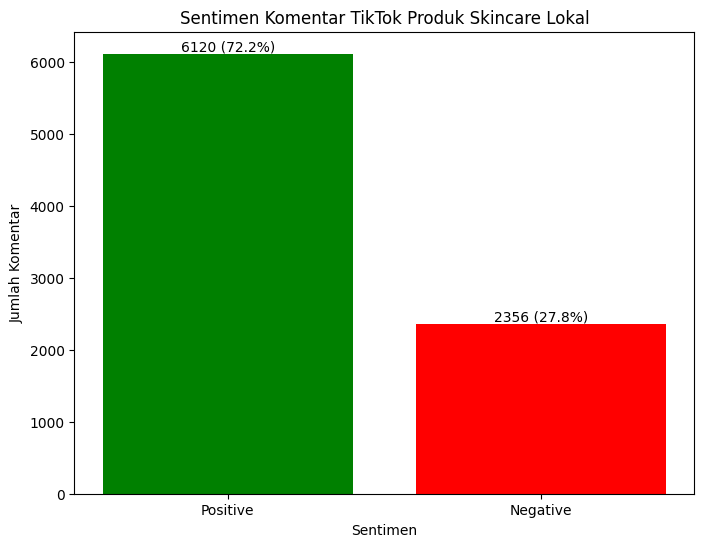

In [56]:
import matplotlib.pyplot as plt

# Data for the bar chart
labels = ['Positive', 'Negative']
sizes = [len(komen_positif), len(komen_negative)]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['green', 'red'])
judul = 'Sentimen Komentar TikTok Produk Skincare Lokal'
plt.title(judul)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Komentar')

# Add percentage labels on top of each bar
for i, v in enumerate(sizes):
    plt.text(i, v + 1, f'{v} ({100*v/total_komen:.1f}%)', ha='center', va='bottom')

plt.show()

##1. WordCloud Sentimen Positif

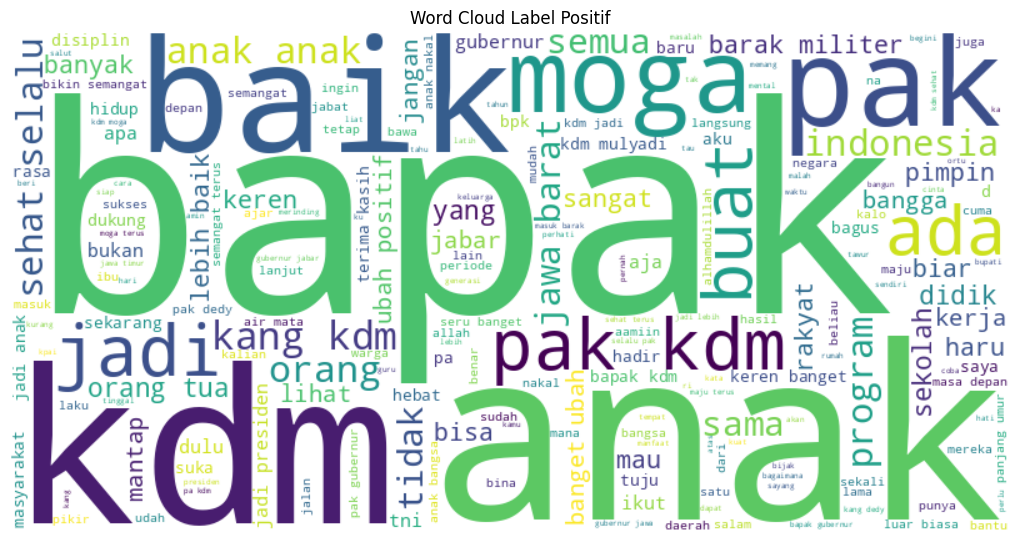

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ambil teks bersih untuk wordcloud
positive_df = df[df['polarity'] == 'positive']
positive_text = ' '.join(
    positive_df['teks_stemming'].dropna().astype(str)
    .loc[lambda x: ~x.str.contains('nan')]
)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Visualisasi
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud Label Positif")
plt.show()


##2. WordCloud Sentimen Negatif

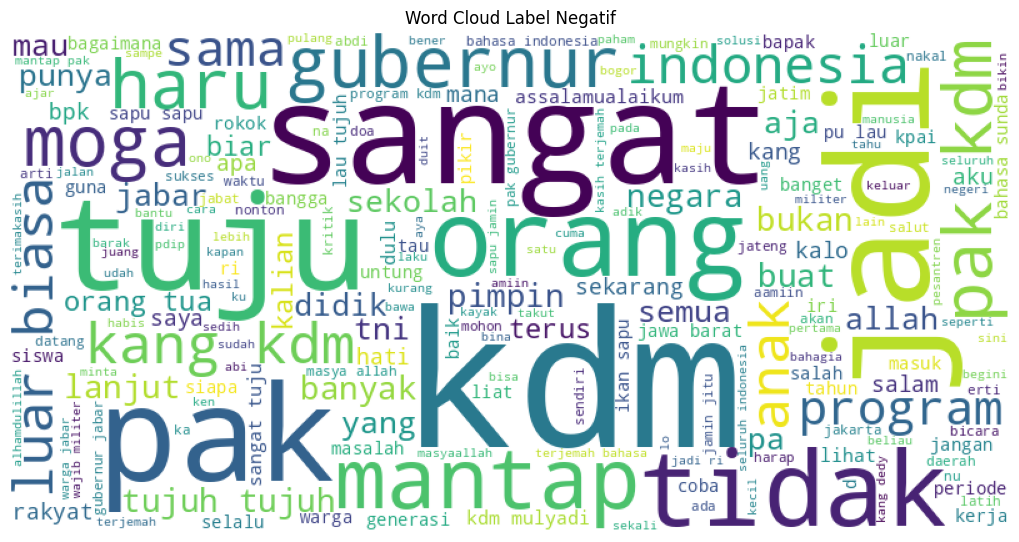

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter untuk label negatif
negative_df = df[df['polarity'] == 'negative']

# Gabungkan semua teks negatif jadi satu string
negative_text = ' '.join(
    negative_df['teks_stemming'].dropna().astype(str)
    .loc[lambda x: ~x.str.contains('nan')]
)

# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Word Cloud Label Negatif')
plt.show()


**Membuat Kolom Untuk Ekstraksi Fitur**

In [59]:
# Define the clean_senticnet function
def clean_senticnet(text):
    # Hapus tanda kurung siku dan koma
    cleaned = re.sub(r'[\[\],]', '', str(text))
    # Hapus spasi berlebih dan ubah ke lowercase
    cleaned = ' '.join(cleaned.split()).lower()
    return cleaned

# Apply the function to create the new column *outside* the function definition
df['cleaned_senticnet'] = df['text_correct_senticnet'].apply(clean_senticnet)

In [60]:
df['cleaned_senticnet']

,cleaned_senticnet
0,'tah' 'dele' 'varel' 'bapak'
1,'keren'
2,'tetap' 'semangat' 'kang' 'kdm' 'pokir' 'korea...
3,'andai' 'dikaltim' 'ada' 'begini' 'aku' 'ikut'
4,'juga' 'ken'
...,...
9906,'assalamualaikum' 'pak' 'permisi' 'titip' 'awa...
9907,'ko' 'aku' 'nang' 'lihat' 'buah' 'ubah' 'kecil...
9908,'kdm' 'bener' 'baru' 'temu' 'sosok' 'beliau' '...
9909,'tuju' 'ayo' 'jempol' 'dukung' 'kdm' 'pimpin' ...


#5. Ekstraksi Fitur

**TF-IDF**

In [61]:
!pip install pandas scikit-learn

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['cleaned_senticnet'])

In [63]:
#melihat jumlah fitur
print(len(tfidf.get_feature_names_out()))

6768


In [64]:
#fitur-fitur yang ada di corpus
print(tfidf.get_feature_names_out())

['aaa' 'aaaaa' 'aaaaarrrgghhhpas' ... 'zona' 'zonk' 'zulhas']


In [65]:
#melihat matriks jumlah token

x_tf_idf = tfidf.transform(df['cleaned_senticnet']).toarray()
x_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [66]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(x_tf_idf, columns=tfidf.get_feature_names_out())
data_tf_idf.to_csv('hasil tfidf.csv', index = False, header = True,index_label=None)

In [67]:
data_tf_idf

,aaa,aaaaa,aaaaarrrgghhhpas,aaah,aaahhhhhhh,aaamiiiin,aacchh,aah,aalamiiin,aalamiin,...,zaman,zein,zeinmereka,zeinsalam,zen,zikir,zippp,zona,zonk,zulhas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#6. Splitting Data

**Splitting Data 80:20**

In [70]:
from sklearn.preprocessing import LabelEncoder

In [71]:
le = LabelEncoder()

df['polarity_encoded'] = le.fit_transform(df['polarity'])

In [72]:
df['polarity_encoded']

,polarity_encoded
0,1
1,1
2,1
3,1
4,1
...,...
9906,0
9907,1
9908,1
9909,0


In [73]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
x = data_tf_idf
y = df['polarity_encoded']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Print the class distribution of the original and split data
print("Original class distribution:")
print(y.value_counts())
print("\nTraining set class distribution:")
print(y_train.value_counts())
print("\nTesting set class distribution:")
print(y_test.value_counts())

Original class distribution:
polarity_encoded
1    6120
0    2356
Name: count, dtype: int64

Training set class distribution:
polarity_encoded
1    4892
0    1888
Name: count, dtype: int64

Testing set class distribution:
polarity_encoded
1    1228
0     468
Name: count, dtype: int64


In [75]:
y_test.value_counts()

,count
polarity_encoded,
1,1228
0,468


#7. Balancing Data

**Balancing Data Training SMOTE**

In [76]:
!pip install imbalanced-learn

In [77]:
from imblearn.over_sampling import SMOTE

# Oversample the training data using SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Print the class distribution before and after SMOTE
print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_resampled.value_counts())

Before SMOTE:
polarity_encoded
1    4892
0    1888
Name: count, dtype: int64

After SMOTE:
polarity_encoded
1    4892
0    4892
Name: count, dtype: int64


polarity_encoded
1    4892
0    4892
Name: count, dtype: int64


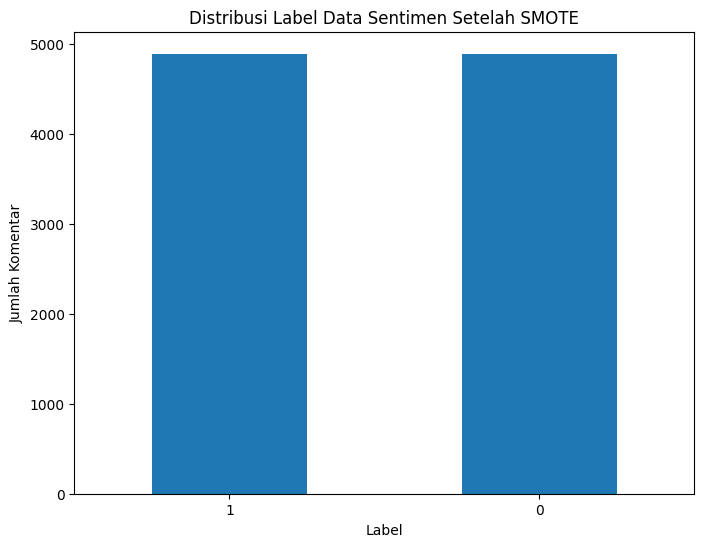

In [78]:
import matplotlib.pyplot as plt
# prompt: buat menjadi grafik label setelah di smote

# Menghitung jumlah setiap label setelah SMOTE
label_counts_resampled = y_train_resampled.value_counts()
print(label_counts_resampled)

# Membuat grafik batang
plt.figure(figsize=(8, 6))
label_counts_resampled.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Jumlah Komentar')
plt.title('Distribusi Label Data Sentimen Setelah SMOTE')
plt.xticks(rotation=0)
plt.show()

#8. Pemodelan

In [79]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)

SVC(kernel='linear')

In [80]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)

MultinomialNB()

###1. NAIVE BAYES TANPA MENGGUNAKAN SMOTE

In [81]:
# prompt: buatkan model naive bayes sebeleum menggunakan smote

from sklearn.naive_bayes import MultinomialNB

# Inisialisasi model Naive Bayes Multinomial
nb_model_no_smote = MultinomialNB()

# Training model Naive Bayes tanpa SMOTE (menggunakan data asli)
nb_model_no_smote.fit(x_train, y_train)

# Prediksi
y_pred_nb_no_smote = nb_model_no_smote.predict(x_test)

# Menampilkan hasil klasifikasi Naive Bayes tanpa SMOTE
print("\n==== Hasil Klasifikasi Naive Bayes Tanpa SMOTE ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb_no_smote):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb_no_smote))



==== Hasil Klasifikasi Naive Bayes Tanpa SMOTE ====
Accuracy: 0.7653
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.16      0.27       468
           1       0.76      1.00      0.86      1228

    accuracy                           0.77      1696
   macro avg       0.85      0.58      0.57      1696
weighted avg       0.81      0.77      0.70      1696



####2. NAIVE BAYES MENGGUNAKAN SMOTE

In [82]:
# prompt: buatkan model naive bayes setelah menggunakan smote

# Inisialisasi model Naive Bayes Multinomial
nb_model_smote = MultinomialNB()

# Training model Naive Bayes menggunakan SMOTE (menggunakan data yang sudah di-resample)
nb_model_smote.fit(x_train_resampled, y_train_resampled)

# Prediksi
y_pred_nb_smote = nb_model_smote.predict(x_test)

# Menampilkan hasil klasifikasi Naive Bayes menggunakan SMOTE
print("\n==== Hasil Klasifikasi Naive Bayes Menggunakan SMOTE ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb_smote):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb_smote))


==== Hasil Klasifikasi Naive Bayes Menggunakan SMOTE ====
Accuracy: 0.8555
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       468
           1       0.89      0.91      0.90      1228

    accuracy                           0.86      1696
   macro avg       0.82      0.81      0.82      1696
weighted avg       0.85      0.86      0.85      1696



###3. SVM TANPA MENGGUNAKAN SMOTE

In [83]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Inisialisasi model SVM dengan kernel linear
svm_model = SVC(kernel='linear', random_state=42)

# Training model tanpa SMOTE (menggunakan data asli)
svm_model.fit(x_train, y_train)

# Prediksi
y_pred = svm_model.predict(x_test)

# Menampilkan hasil klasifikasi
print("\n==== Hasil Klasifikasi Tanpa SMOTE - Kernel: linear ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


==== Hasil Klasifikasi Tanpa SMOTE - Kernel: linear ====
Accuracy: 0.9116
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       468
           1       0.94      0.94      0.94      1228

    accuracy                           0.91      1696
   macro avg       0.89      0.89      0.89      1696
weighted avg       0.91      0.91      0.91      1696



In [84]:
# Daftar kernel SVM
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Dictionary untuk menyimpan hasil prediksi
y_preds_no_smote = {}

# Klasifikasi untuk setiap kernel tanpa SMOTE
for kernel in kernels:
    print(f"\n==== Hasil Klasifikasi Tanpa SMOTE - Kernel: {kernel} ====")

    # Inisialisasi model SVM
    if kernel == 'poly':
        svm_model = SVC(kernel=kernel, degree=3, random_state=42)
    else:
        svm_model = SVC(kernel=kernel, random_state=42)

    # Training model tanpa SMOTE (menggunakan data asli)
    svm_model.fit(x_train, y_train)

    # Prediksi
    y_pred = svm_model.predict(x_test)

    # Simpan hasil prediksi untuk masing-masing kernel
    y_preds_no_smote[kernel] = y_pred

    # Menampilkan hasil klasifikasi
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


==== Hasil Klasifikasi Tanpa SMOTE - Kernel: linear ====
Accuracy: 0.9116
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       468
           1       0.94      0.94      0.94      1228

    accuracy                           0.91      1696
   macro avg       0.89      0.89      0.89      1696
weighted avg       0.91      0.91      0.91      1696


==== Hasil Klasifikasi Tanpa SMOTE - Kernel: rbf ====
Accuracy: 0.8850
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.75       468
           1       0.88      0.98      0.92      1228

    accuracy                           0.89      1696
   macro avg       0.90      0.81      0.84      1696
weighted avg       0.89      0.89      0.88      1696


==== Hasil Klasifikasi Tanpa SMOTE - Kernel: poly ====
Accuracy: 0.7871
Classification Report:
              precision    recall  f1-score   support

  

####4. SVM MENGGUNAKAN SMOTE

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Inisialisasi model SVM dengan kernel linear
svm_model = SVC(kernel='linear', random_state=42)

# Training model
svm_model.fit(x_train_resampled, y_train_resampled)

# Prediksi
y_pred = svm_model.predict(x_test)

# Menampilkan hasil klasifikasi
print("\n==== Hasil Klasifikasi Kernel: linear ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Daftar kernel SVM
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Dictionary untuk menyimpan hasil prediksi
y_preds = {}

# Klasifikasi untuk setiap kernel
for kernel in kernels:
    print(f"\n==== Hasil Klasifikasi Kernel: {kernel} ====")

    # Inisialisasi model SVM
    if kernel == 'poly':
        svm_model = SVC(kernel=kernel, degree=3, random_state=42)
    else:
        svm_model = SVC(kernel=kernel, random_state=42)

    # Training model
    svm_model.fit(x_train_resampled, y_train_resampled)

    # Prediksi
    y_pred = svm_model.predict(x_test)

    # Simpan hasil prediksi untuk masing-masing kernel
    y_preds[kernel] = y_pred  # Menyimpan prediksi untuk setiap kernel

    # Menampilkan hasil klasifikasi
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

#9. Evaluasi Model

**Confusion Matrix**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Label kelas
labels = np.unique(y_test)

y_pred_nb = nb_model.predict(x_test)
y_pred_lr = svm_model.predict(x_test)

# Confusion matrix Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Confusion matrix SVM
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()


#10. Prediksi Sentimen

In [ ]:
def replace_taboo_words(text, kamus):
    for kata_tidak_baku, kata_baku in kamus.items():
        text = text.replace(kata_tidak_baku, kata_baku)
    return text


In [ ]:
kamus_tidak_baku = {
    "bgt": "banget",
    "ga": "tidak",
    "gk": "tidak",
    "bgt": "banget",
    "jelek": "buruk"
}


In [ ]:
import pandas as pd # Moved import outside function for better practice

def predict_sentiment(text):
    text = clean_text(text)
    text = casefolding(text)
    text = replace_taboo_words(text, kamus_tidak_baku)
    stemmed_words = stem_text(text) # stem_text returns a list of words
    text = ' '.join(stemmed_words) # Join the list of words into a single string

    # Transformasi ke vektor TF-IDF
    text_vec = tfidf.transform([text])

    # Ubah ke dense array
    text_vec_dense = text_vec.toarray()

    # Buat dummy feature names agar tidak warning
    text_vec_df = pd.DataFrame(text_vec_dense, columns=tfidf.get_feature_names_out())

    # 'lr_model' was not defined. Using 'svm_model' (trained with SMOTE in cell 0pmK2NNLtU3_) for prediction.
    predicted_sentiment = svm_model.predict(text_vec_df)[0]

    return predicted_sentiment


new_text = "produknya cantik"
predicted_label = predict_sentiment(new_text)
print(f"Text: {new_text}")
print(f"Predicted Sentiment: {predicted_label}\n")

new_text = "produknya jelek"
predicted_label = predict_sentiment(new_text)
print(f"Text: {new_text}")
print(f"Predicted Sentiment: {predicted_label}\n")

new_text = "harus beli produk ini karena benar dan cantik"
predicted_label = predict_sentiment(new_text)
print(f"Text: {new_text}")
print(f"Predicted Sentiment: {predicted_label}\n")

In [ ]:
print("bagus" in tfidf.get_feature_names_out())


In [ ]:
def predict_sentiment(text):
    text = clean_text(text)
    text = casefolding(text)
    text = replace_taboo_words(text, kamus_tidak_baku)
    # text = process_text(word_tokenize(text))  # jika tidak perlu, bisa skip
    text = stemming(text)

    print("Hasil akhir preprocessing:", text)
    ...


In [ ]:
"bagus" in " ".join(x_train)  # atau X_train_smote jika kamu pakai yang versi SMOTE


In [ ]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression

# Buat objek model kosong untuk Naive Bayes
# model_nb = MultinomialNB()
# print("=== Default Parameters - MultinomialNB ===")
#print(model_nb.get_params())
#print("\n")

# Buat objek model kosong untuk Logistic Regression
#model_lr = LogisticRegression()
##print("=== Default Parameters - LogisticRegression ===")
#print(model_lr.get_params())


In [ ]:
#=== Default Parameters - MultinomialNB ===
#{'alpha': 1.0, 'fit_prior': True, 'class_prior': None}

#=== Default Parameters - LogisticRegression ===
#{'penalty': 'l2', 'dual': False, 'C': 1.0, 'solver': 'lbfgs', 'max_iter': 100, ...}


In [ ]:
#model_nb = MultinomialNB(alpha=0.5)
#model_svm = Supportvectormechine(solver='liblinear', max_iter=200)


In [ ]:
#from sklearn.svm import SVC

# Buat objek model kosong
#model = SVC()

# Tampilkan semua parameter dan nilai defaultnya
#print(model.get_params())

In [ ]:
# Menghapus baris yang hasil lower_text-nya kosong
#df = df[df['lower_text'].str.strip() != '']

In [ ]:
#jumlah_kosong = (df['lower_text'].str.strip() == '').sum()
#print(f"Jumlah data kosong setelah lower_text: {jumlah_kosong}")